In [1]:
from networkit import *
%matplotlib inline
import matplotlib.pyplot as plt
import time
from sklearn import *
import numpy as np
import random
from cython import *
from math import isnan

No module named 'seaborn'


In [2]:
cd ~/Thesis/NetworKit-Esders

/home/xza/Thesis/NetworKit-Esders


In [3]:
def drawROC(indexName, predictions):
    X, Y = roc.getCurve(predictions)
    plt.suptitle(indexName, fontsize=14, fontweight="bold")
    plt.xticks([z / 10 for z in range(11)])
    plt.yticks([z / 10 for z in range(11)])
    plt.xlabel("False positive rate")
    plt.ylabel("True positive rate")
    plt.axis([0, 1, 0, 1])
    curve, = plt.plot(X, Y, label=indexName)
    plt.plot([0, 1], [0, 1], ls='--')
    plt.legend(handles=[curve], loc=4)
def drawPR(indexName, predictions):
    X, Y = pr.getCurve(predictions)
    plt.suptitle(indexName, fontsize=14, fontweight="bold")
    plt.xticks([z / 10 for z in range(11)])
    plt.yticks([z / 10 for z in range(11)])
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.axis([0, 1, 0, 1])
    curve, = plt.plot(X, Y, label=indexName)
    plt.legend(handles=[curve])
def drawROCs(supTitle, **args):
    predictions = args["predictions"]
    indexNames = args["indexNames"]
    plt.suptitle(supTitle, fontsize=14, fontweight="bold")
    plt.xticks([z / 10 for z in range(11)])
    plt.yticks([z / 10 for z in range(11)])
    plt.xlabel("False positive rate")
    plt.ylabel("True positive rate")
    plt.axis([0, 1, 0, 1])
    plt.plot([0, 1], [0, 1], '#aaaaaa', ls='--')
    handles = []
    for i in range(0, len(indexNames)):
        X, Y = roc.getCurve(predictions[i])
        curve, = plt.plot(X, Y, label=indexNames[i])
        handles.append(curve)
    plt.legend(handles=handles, loc=4, fontsize=10)

In [4]:
#testGraph, trainingGraph = linkprediction.readGraph("input/out.youtube-u-growth", 0.01)
testGraph = readGraph("input/CA-CondMat_tab-sep.edgelist", Format.EdgeListTabOne)
testGraph.numberOfEdges()

93497

In [5]:
roc = linkprediction.ROCMetric(testGraph)
pr = linkprediction.PrecisionRecallMetric(testGraph)

In [6]:
trainingGraph = linkprediction.TrainingGraphSampler.byPercentage(testGraph, 0.9)
trainingGraph.numberOfEdges()

84147

In [7]:
featureGraph = linkprediction.TrainingGraphSampler.byCount(trainingGraph, trainingGraph.numberOfEdges() - 25000)
featureGraph.numberOfEdges()

59147

In [8]:
featureKatzIndex = linkprediction.KatzIndex(featureGraph, 5, 0.005)
featureCommonNeighborsIndex = linkprediction.CommonNeighborsIndex(featureGraph)
featureJaccardIndex = linkprediction.JaccardIndex(featureGraph)
featurePreferentialAttachmentIndex = linkprediction.PreferentialAttachmentIndex(featureGraph)
featureAdamicAdarIndex = linkprediction.AdamicAdarIndex(featureGraph)
featureUDegreeIndex = linkprediction.UDegreeIndex(featureGraph)
featureVDegreeIndex = linkprediction.VDegreeIndex(featureGraph)
featureAlgebraicDistanceIndex = linkprediction.AlgebraicDistanceIndex(featureGraph, 5, 15)
featureAlgebraicDistanceIndex.preprocess()
featureReversedNeighborhoodDistanceIndex = linkprediction.ReversedNeighborhoodDistanceIndex(featureGraph)
featureTotalNeighborsIndex = linkprediction.TotalNeighborsIndex(featureGraph)
featureNeighborsMeasureIndex = linkprediction.NeighborsMeasureIndex(featureGraph)
featureSameCommunityIndex = linkprediction.SameCommunityIndex(featureGraph)
featureAdjustedRandIndex = linkprediction.AdjustedRandIndex(featureGraph)
featureResourceAllocationIndex = linkprediction.ResourceAllocationIndex(featureGraph)

katzIndex = linkprediction.KatzIndex(trainingGraph, 5, 0.005)
commonNeighborsIndex = linkprediction.CommonNeighborsIndex(trainingGraph)
jaccardIndex = linkprediction.JaccardIndex(trainingGraph)
preferentialAttachmentIndex = linkprediction.PreferentialAttachmentIndex(trainingGraph)
adamicAdarIndex = linkprediction.AdamicAdarIndex(trainingGraph)
uDegreeIndex = linkprediction.UDegreeIndex(trainingGraph)
vDegreeIndex = linkprediction.VDegreeIndex(trainingGraph)
algebraicDistanceIndex = linkprediction.AlgebraicDistanceIndex(trainingGraph, 5, 15)
algebraicDistanceIndex.preprocess()
reversedNeighborhoodDistanceIndex = linkprediction.ReversedNeighborhoodDistanceIndex(trainingGraph)
totalNeighborsIndex = linkprediction.TotalNeighborsIndex(trainingGraph)
neighborsMeasureIndex = linkprediction.NeighborsMeasureIndex(trainingGraph)
sameCommunityIndex = linkprediction.SameCommunityIndex(trainingGraph)
adjustedRandIndex = linkprediction.AdjustedRandIndex(trainingGraph)
resourceAllocationIndex = linkprediction.ResourceAllocationIndex(trainingGraph)

In [9]:
featureLinkPredictors = (featureCommonNeighborsIndex, featureJaccardIndex, featureAdamicAdarIndex, featurePreferentialAttachmentIndex, featureUDegreeIndex, featureVDegreeIndex, featureReversedNeighborhoodDistanceIndex, featureAlgebraicDistanceIndex, featureTotalNeighborsIndex, featureNeighborsMeasureIndex, featureSameCommunityIndex, featureResourceAllocationIndex, featureAdjustedRandIndex)
linkPredictors = (commonNeighborsIndex, jaccardIndex, adamicAdarIndex, preferentialAttachmentIndex, uDegreeIndex, vDegreeIndex, reversedNeighborhoodDistanceIndex, algebraicDistanceIndex, totalNeighborsIndex, neighborsMeasureIndex, sameCommunityIndex, resourceAllocationIndex, adjustedRandIndex)

In [60]:
twoHopInTest = linkprediction.MissingLinksFinder(trainingGraph).findRandomly(3, 100000)
twoHopInFeature = linkprediction.MissingLinksFinder(featureGraph).findRandomly(3, 100000)

In [61]:
# Undersample the negatives from the randomly drawn 2-hop links in FEATURE, until len(pos) = len(neg)
labels = linkprediction.getClasses(twoHopInFeature, trainingGraph)
random.shuffle(twoHopInFeature)

negativesNeeded = sum(labels)
positives = []
negatives = []
i = 0
num = len(twoHopInFeature)
for i in range(0, num):
    e = twoHopInFeature[i]
    if (len(negatives) < negativesNeeded) and not (trainingGraph.hasEdge(e[0], e[1]) or trainingGraph.hasEdge(e[1], e[0])):
        negatives.append(e)
    elif trainingGraph.hasEdge(e[0], e[1]):
        positives.append(e)
nodePairsTrain = negatives + positives
nodePairsTrain.sort()

In [62]:
# Undersample the negatives from the randomly drawn 2-hop links in TRAIN, until len(pos) = len(neg)
labels = linkprediction.getClasses(twoHopInTest, testGraph)
random.shuffle(twoHopInTest)

negativesNeeded = sum(labels)
positives = []
negatives = []
i = 0
num = len(twoHopInTest)
for i in range(0, num):
    e = twoHopInTest[i]
    if (len(negatives) < negativesNeeded) and not (testGraph.hasEdge(e[0], e[1]) or testGraph.hasEdge(e[1], e[0])):
        negatives.append(e)
    elif testGraph.hasEdge(e[0], e[1]):
        positives.append(e)
nodePairsTest = negatives + positives
nodePairsTest.sort()

In [63]:
#trainingGraphEdges = trainingGraph.edges()

#deltaTrainingTestGraph = Graph(testGraph)
#for x in trainingGraphEdges:
#    deltaTrainingTestGraph.removeEdge(x[0], x[1])
#deltaTestEdges = deltaTrainingTestGraph.edges()
#len(deltaTestEdges)

In [64]:
#testPositives = deltaTestEdges
#testNegatives = []
#i = 0
#while len(testNegatives) < len(testPositives):
#    e = nodePairsTest[i]
#    if not (testGraph.hasEdge(e[0], e[1]) or testGraph.hasEdge(e[1], e[0])):
#        testNegatives.append(e)
#    i += 1
#nodePairsTest = testNegatives + testPositives
#random.shuffle(nodePairsTrain)
#len(nodePairsTest)

In [65]:
labelTrain = linkprediction.getClasses(nodePairsTrain, trainingGraph)
featureTrain = linkprediction.getSamples(nodePairsTrain, *featureLinkPredictors)

In [66]:
labelTest = linkprediction.getClasses(nodePairsTest, testGraph)
featureTest = linkprediction.getSamples(nodePairsTest, *linkPredictors)

In [67]:
i = 0
j = 0
for x in featureTrain:
    j = 0
    for y in x:
        if isnan(y):
            print(i, j)
        j += 1
    i += 1

In [68]:
dtc = ensemble.BaggingClassifier(tree.DecisionTreeClassifier(), max_features=0.5, n_jobs=-1)
#dtc = ensemble.AdaBoostClassifier()
dtc.fit(featureTrain, labelTrain)

BaggingClassifier(base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            random_state=None, splitter='best'),
         bootstrap=True, bootstrap_features=False, max_features=0.5,
         max_samples=1.0, n_estimators=10, n_jobs=-1, oob_score=False,
         random_state=None, verbose=0)

In [69]:
supPreds = dtc.predict_proba(featureTest)
predLabelTest = [pred[1] for pred in supPreds]

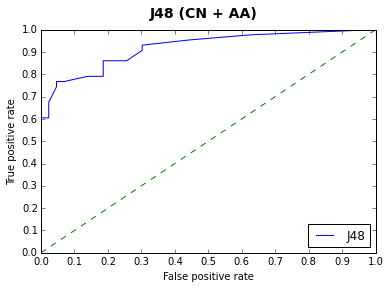

In [70]:
fpr, tpr, thresholds = metrics.roc_curve(labelTest, predLabelTest)
plt.suptitle("J48 (CN + AA)", fontsize=14, fontweight="bold")
plt.xticks([z / 10 for z in range(11)])
plt.yticks([z / 10 for z in range(11)])
plt.xlabel("False positive rate")
plt.ylabel("True positive rate")
plt.axis([0, 1, 0, 1])
j48, = plt.plot(fpr, tpr, label="J48")
plt.plot([0, 1], [0, 1], ls='--')
plt.legend(handles=[j48], loc=4)

In [71]:
metrics.roc_auc_score(labelTest, predLabelTest)

0.91941590048674959

In [72]:
len(labelTest)

86

In [77]:
startTime = time.time()
predictions = commonNeighborsIndex.runOnParallel(nodePairsTest)
print("%s seconds" % (time.time() - startTime))

0.006604909896850586 seconds


In [78]:
drawROC("Common Neighbors Index", predictions)

IndexError: vector::_M_range_check

In [79]:
startTime = time.time()
predictions = jaccardIndex.runOnParallel(nodePairsTest)
print("%s seconds" % (time.time() - startTime))

0.0018401145935058594 seconds


In [80]:
drawROC("Jaccard Index", predictions)

IndexError: vector::_M_range_check

In [24]:
roc.getAreaUnderCurve()

0.8950403552601973